# Solution to the system

This notebook includes code related to methods and results for solving the ODE. This analysis was used to create results and figures for the final paper.

----

### Imports

In [179]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
%matplotlib inline

### The system of equations (originally used in Battista et al)

In [300]:
def opioid(state, t, alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    S, P, A, R = state
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

### Our modified version

In [301]:
def opioid(state, t, epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star):
    
    '''
    modification 1: nu A is assumed to be 1 - sigma - delta - mu
    
    modification 2: beta and xi are replaced with beta_1 and beta_2 
    
    epsilon may also be assumed to be 1 - gamma to simplify parameter space, but is not employed here
    
    '''
    S, P, A, R = state

    # System of differential equations
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + (epsilon)*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + beta_1*S*A + beta_2*S*P + R*(1 - delta - mu) - (zeta + mu_star)*A
    R_prime = zeta*A - R
    
    # Return derivatives
    return [S_prime, P_prime, A_prime, R_prime]

### Parameters according to the paper

In [323]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
gamma = 0.26 # rate of addiction among prescribed users
mu = 0.00824 # death rate
mu_star = 0.00834 # death rate of addicts
delta = 0.1 # R to S rate. 0.1 is default

### Our additions and overrides to the cited parameters

In [326]:
gamma = 0.1
beta_1 = 0.05
beta_2 = 0.1
alpha = 0.05 # prescription rate. could be 0-1
zeta = 0.5 # rate of A entry into quitting or rehab. could be 0-1

### Solve the system

0.206786647212


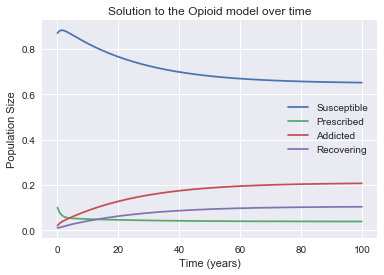

In [336]:
# times to solve at
t = np.linspace(0, 100, 160)

# initial state
state0 = [0.87, 0.1, 0.02, 0.01]
numerical_sol, output = sp.integrate.odeint(opioid, state0, t, full_output=1,args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star))
S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

# plot figure
plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label= "Prescribed")
plt.plot(t, A, label= "Addicted")
plt.plot(t, R, label= "Recovering")
plt.title("Solution to the Opioid model over time")
plt.xlabel("Time (years)")
plt.ylabel("Population Size")
plt.legend()
plt.savefig('opioid_solution.png')
print A[-1]

### Check the stiffness and method used by odeint: 1=Adam's method (explicit multistep method for nonstiff systems)

In [337]:
# Odeint returns "mused"
output['mused']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Check the step-size used through Adam's method

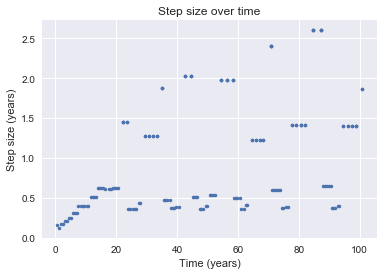

In [338]:
# plot figure
plt.plot(output['tcur'],output['hu'], '.')
plt.title("Step size over time")
plt.xlabel("Time (years)")
plt.ylabel("Step size (years)")

# save figure
plt.savefig('step_size_over_time.png')

### Check sensitivity to initial conditions

In [339]:
# initial state
state = [0.87, 0.1, 0.02, 0.01]
initial_states = np.empty((10,4))

# Introduce noise into s, p, a, and r
for i in range(10):
    p = state[1] + np.random.normal(0, 0.04, 1)
    a = state[2] + np.random.normal(0, 0.008, 1)
    r = state[3] + np.random.normal(0, 0.004, 1)
    s = 1.0 - p - a - r
    initial_states[i] = [s,p,a,r]
initial_states    

array([[  8.64468244e-01,   1.13226092e-01,   1.28893580e-02,
          9.41630547e-03],
       [  8.73279225e-01,   1.09551628e-01,   1.36260698e-02,
          3.54307690e-03],
       [  8.39168381e-01,   1.30523557e-01,   2.47648831e-02,
          5.54317892e-03],
       [  8.70635618e-01,   1.19737847e-01,   6.80872681e-04,
          8.94566293e-03],
       [  8.58614605e-01,   1.22066855e-01,   1.16928383e-02,
          7.62570122e-03],
       [  8.80915911e-01,   8.91089937e-02,   1.73710347e-02,
          1.26040603e-02],
       [  9.39547207e-01,   2.81964485e-02,   2.01652372e-02,
          1.20911070e-02],
       [  8.16204279e-01,   1.50053962e-01,   2.46306494e-02,
          9.11110978e-03],
       [  8.05721497e-01,   1.59306174e-01,   2.90161985e-02,
          5.95613083e-03],
       [  8.59570944e-01,   1.11408471e-01,   2.43357663e-02,
          4.68481952e-03]])

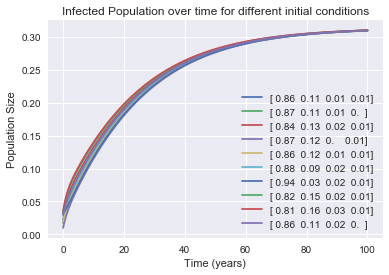

In [340]:
# times to solve at
t = np.linspace(0, 100, 300)

# Loop through each of the possible initial states and solve the system
for state0 in initial_states:
    
    # solve the system
    numerical_sol, output = sp.integrate.odeint(opioid, state0, t, full_output=1,args=(epsilon, alpha, beta_1, beta_2, gamma, zeta, delta, mu, mu_star))
    S = numerical_sol[:,0]
    P = numerical_sol[:,1]
    A = numerical_sol[:,2]
    R = numerical_sol[:,3]
    
    # Plot the solution
    plt.plot(t, R+A, label= np.round(np.array([S[0], P[0], A[0], R[0]]),2))
    plt.title("Infected Population over time for different initial conditions")
    plt.xlabel("Time (years)")
    plt.ylabel("Population Size")
    
plt.legend()

# Save the fiture
plt.savefig('sensitivity_initial_conditions.png')